In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import ttim

Head data is generated for a pumping test in a two-aquifer model. The well starts pumping at time $t=0$ with a discharge $Q=800$ m$^3$/d. The head is measured in an observation well 10 m from the pumping well. The thickness of the aquifer is 20 m. Questions:

1. Determine the optimal values of the hydraulic conductivity and specific storage coefficient of the aquifer when the aquifer is approximated as confined. Use a least squares approach and make use of the `fmin` function of `scipy.optimize` to find the optimal values. Plot the data with dots and the best-fit model in one graph. Print the optimal values of $k$ and $S_s$ to the screen as well as the root mean squared error of the residuals. 

2. Repeat Question 1 but now approximate the aquifer as semi-confined. Plot the data with dots and the best-fit model in one graph. Print to the screen the optimal values of $k$, $S_s$ and $c$  to the screen as well as the root mean squared error of the residuals. Is the semi-cofined model a better fit than the confined model?

In [2]:
def generate_data():
    # 2 layer model with some random error
    ml = ttim.ModelMaq(
        kaq=[10, 20],
        z=[0, -20, -22, -42],
        c=[1000],
        Saq=[0.0002, 0.0001],
        tmin=0.001,
        tmax=100,
    )
    ttim.Well(ml, 0, 0, rw=0.3, tsandQ=[(0, 800)])
    ml.solve()
    t = np.logspace(-2, 1, 100)
    h = ml.head(10, 0, t)
    plt.figure()
    r = 0.01 * rnd.random(100)
    n = np.zeros_like(r)
    # alpha = 0.8
    for i in range(1, len(n)):
        n[i] = 0.8 * n[i - 1] + r[i]
    ho = h[0] + n
    plt.plot(t, ho, ".")
    data = np.zeros((len(ho), 2))
    data[:, 0] = t
    data[:, 1] = ho
    # np.savetxt('pumpingtestdata.txt', data, fmt='%2.3f', header='time (d), head (m)')
    return data

self.neq  1
solution complete


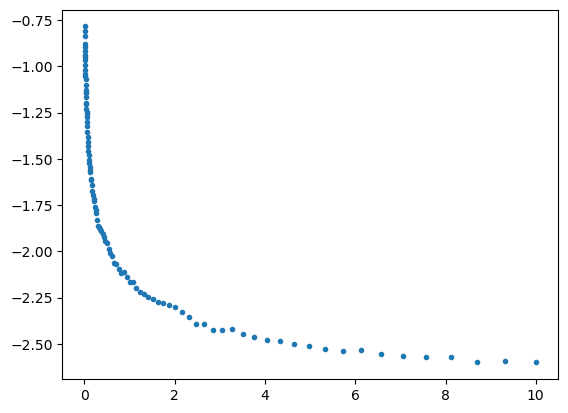

In [3]:
rnd = np.random.default_rng(11)
data = generate_data()
to = data[:, 0]
ho = data[:, 1]

In [4]:
def func(p, to=to, ho=ho, returnmodel=False):
    k = p[0]
    S = p[1]
    ml = ttim.ModelMaq(kaq=k, z=[0, -20], Saq=S, tmin=0.001, tmax=100)
    ttim.Well(ml, 0, 0, rw=0.3, tsandQ=[(0, 800)])
    ml.solve(silent=True)
    if returnmodel:
        return ml
    h = ml.head(10, 0, to)
    return np.sum((h[0] - ho) ** 2)

In [5]:
from scipy.optimize import fmin

lsopt = fmin(func, [10, 1e-4])
print("optimal parameters:", lsopt)
print("rmse:", np.sqrt(func(lsopt) / len(ho)))

Optimization terminated successfully.
         Current function value: 0.216911
         Iterations: 35
         Function evaluations: 71
optimal parameters: [1.16407991e+01 1.16006081e-04]
rmse: 0.04657368512672105


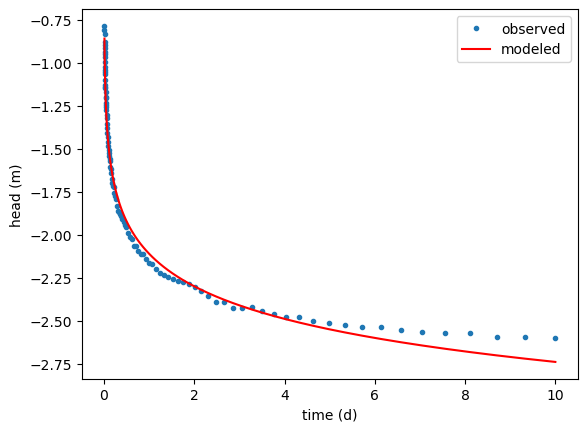

In [6]:
ml = func(lsopt, returnmodel=True)
plt.figure()
plt.plot(data[:, 0], data[:, 1], ".", label="observed")
hm = ml.head(10, 0, to)
plt.plot(to, hm[0], "r", label="modeled")
plt.legend()
plt.xlabel("time (d)")
plt.ylabel("head (m)")

In [7]:
cal = ttim.Calibrate(ml)
cal.set_parameter(name="kaq0", initial=10, pmin=0.1, pmax=1000)
cal.set_parameter(name="Saq0", initial=1e-4, pmin=1e-5, pmax=1e-3)
cal.series(name="obs1", x=10, y=0, layer=0, t=to, h=ho)
cal.fit(report=False)
print("rmse:", cal.rmse())

.....................
Fit succeeded.
rmse: 0.04657368442245464


In [8]:
cal.parameters

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,11.641202,0.110740,0.951278,0.10000,1000.000,10.0000,[11.64120169590218]
Saq0,0.000116,0.000006,5.251431,0.00001,0.001,0.0001,[0.0001159878113151273]


### Model as semi-confined

In [9]:
def func2(p, to=to, ho=ho, returnmodel=False):
    k = p[0]
    S = p[1]
    c = p[2]
    ml = ttim.ModelMaq(
        kaq=k, z=[2, 0, -20], Saq=S, c=c, topboundary="semi", tmin=0.001, tmax=100
    )
    ttim.Well(ml, 0, 0, rw=0.3, tsandQ=[(0, 800)])
    ml.solve(silent=True)
    if returnmodel:
        return ml
    h = ml.head(10, 0, to)
    return np.sum((h[0] - ho) ** 2)

In [10]:
lsopt2 = fmin(func2, [10, 1e-4, 1000])
print("optimal parameters:", lsopt2)
print("rmse:", np.sqrt(func2(lsopt2) / len(ho)))

Optimization terminated successfully.
         Current function value: 0.016202
         Iterations: 109
         Function evaluations: 225
optimal parameters: [1.03909094e+01 1.76382940e-04 2.02594461e+03]
rmse: 0.012728539913473325


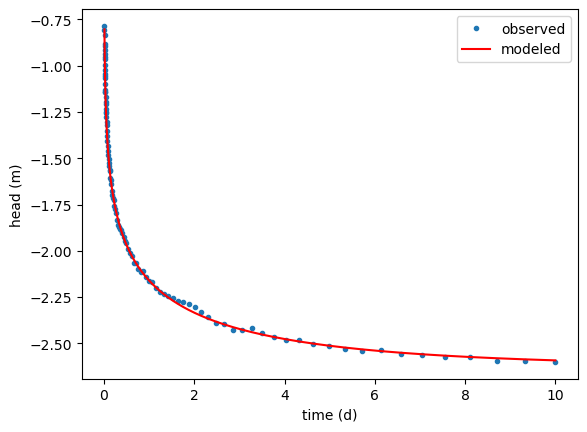

In [11]:
ml = func2(lsopt2, returnmodel=True)
plt.figure()
plt.plot(data[:, 0], data[:, 1], ".", label="observed")
hm = ml.head(10, 0, to)
plt.plot(to, hm[0], "r", label="modeled")
plt.legend()
plt.xlabel("time (d)")
plt.ylabel("head (m)")

In [12]:
ml = ttim.ModelMaq(
    kaq=10, z=[2, 0, -20], Saq=1e-4, c=1000, topboundary="semi", tmin=0.001, tmax=100
)
w = ttim.Well(ml, 0, 0, rw=0.3, tsandQ=[(0, 800)])
ml.solve(silent=True)

In [13]:
cal = ttim.Calibrate(ml)
cal.set_parameter(name="kaq0", initial=10)
cal.set_parameter(name="Saq0", initial=1e-4)
cal.set_parameter(name="c0", initial=1000)
cal.series(name="obs1", x=10, y=0, layer=0, t=to, h=ho)
cal.fit(report=False)
cal.parameters

....................................
Fit succeeded.


,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,10.391031,0.042659,0.410534,-inf,inf,10.0000,[10.391031434824104]
Saq0,0.000176,0.000003,1.669487,-inf,inf,0.0001,[0.0001763801510490785]
c0,2026.589798,96.474098,4.760416,-inf,inf,1000.0000,[2026.5897975040664]


In [14]:
cal.rmse(), ml.aq.kaq

(0.01272855261536183, array([10.39103143]))

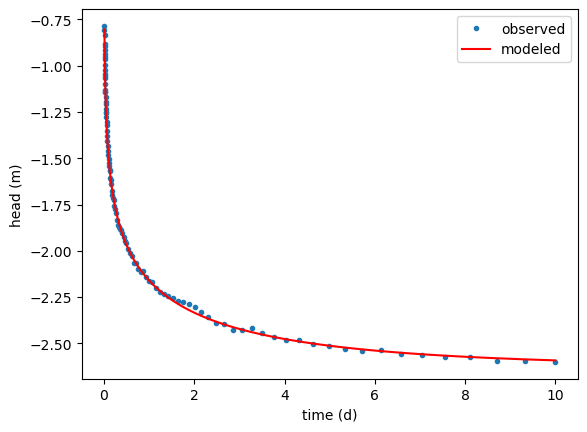

In [15]:
plt.figure()
plt.plot(data[:, 0], data[:, 1], ".", label="observed")
hm = ml.head(10, 0, to)
plt.plot(to, hm[0], "r", label="modeled")
plt.legend()
plt.xlabel("time (d)")
plt.ylabel("head (m)")